In [1]:
from data_classes import LAQNData, HealthData, MetData, IncomeData
from plot_functions import plot_on_map
from os import path, listdir
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import geopandas as gpd
import zipfile as zpf
import httplib2
from bs4 import BeautifulSoup, SoupStrainer
from openpyxl import load_workbook

/home/users/mwlw3/miniconda3/envs/AQmort/lib/python3.8/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
# LAQN site-level data
species = "NO2"
region = "London"
air_quality = LAQNData(species, region)

In [3]:
AQ_df = air_quality.read("laqn-raw")
AQ_df.shape

wandb: Downloading large artifact laqn-raw:latest, 1407.16MB. 198 files... Done. 0:0:0.1


(219169, 198)

In [4]:
# Set up a london boroughs map
tmp_folder = f"/home/users/mwlw3/AQmortality/tmp/"
london_boroughs_gdf = gpd.read_file(path.join(tmp_folder, "london_wards_coordinates", "london_wards_coordinates.shp")).dissolve(by="BOROUGH")

In [5]:
london_gdf = london_boroughs_gdf.dissolve()

In [45]:
request = requests.get("http://api.erg.kcl.ac.uk/AirQuality/Information/MonitoringSites/GroupName=London/Json")
london_sites_df = pd.DataFrame(request.json()['Sites']['Site'])
london_sites_df = london_sites_df.loc[london_sites_df["@Latitude"]!=""]
london_sites_df = london_sites_df.loc[london_sites_df["@Latitude"].astype(float)>51]

lat = london_sites_df["@Latitude"].values
lon = london_sites_df["@Longitude"].values

# Create a geopandas dataframe
london_sites_gdf = gpd.GeoDataFrame(london_sites_df, geometry=gpd.points_from_xy(lon, lat))
london_sites_gdf.shape

(247, 17)

### LAQN sites

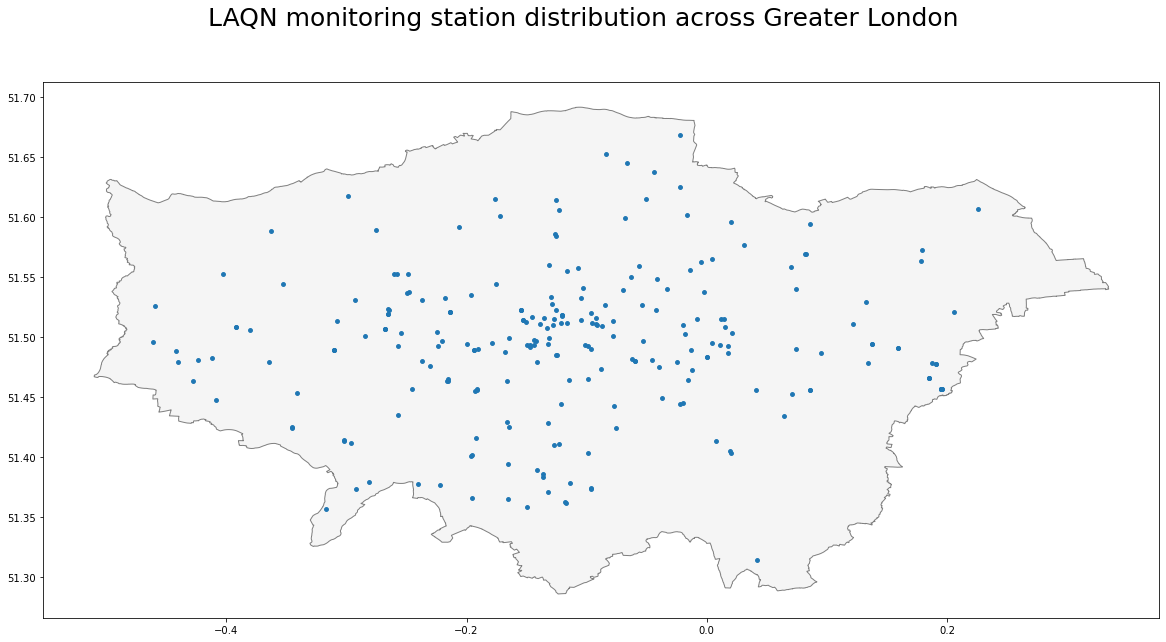

In [7]:
plot_on_map(london_sites_gdf, london_gdf, 
            title="LAQN monitoring station distribution across Greater London", 
            data_markersize=15,  
            map_edge_color="gray", axis="on")

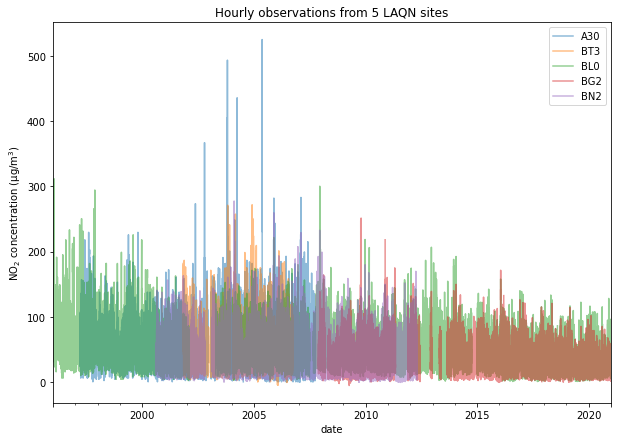

In [8]:
AQ_df[AQ_df.columns[0:5]].plot(alpha=0.5, figsize=(10,7))
plt.ylabel("NO$_2$ concentration (µg/m$^3$)")
plt.xlabel("date")
plt.title("Hourly observations from 5 LAQN sites")
plt.show()

In [49]:
london_sites_df= pd.merge(london_sites_df, pd.DataFrame(AQ_df.isna().sum()/len(AQ_df), columns=["NaN fraction"]), left_on="@SiteCode", right_index=True)
london_sites_pivot_df = pd.pivot_table(london_sites_df, values="NaN fraction", index="@LocalAuthorityName", columns="@SiteCode")

<AxesSubplot:xlabel='@LocalAuthorityName'>

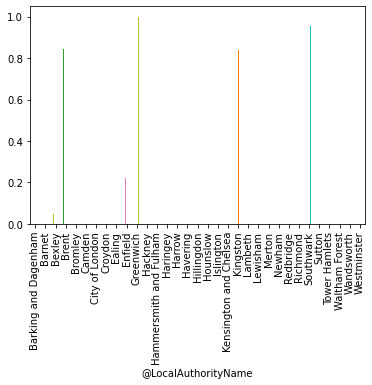

In [52]:
london_sites_pivot_df.plot.bar(legend=False)

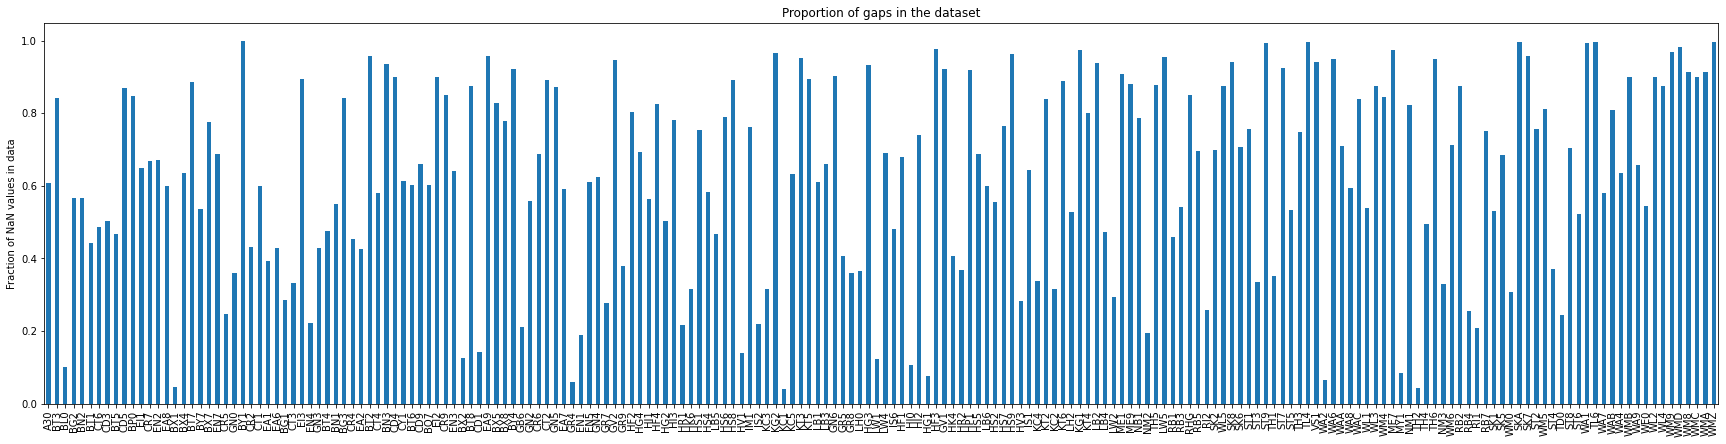

In [25]:
pd.DataFrame(AQ_df.isna().sum()/len(AQ_df)).plot.bar(figsize=(30,7), legend=False)
plt.ylabel("Fraction of NaN values in data")
# plt.xlabel("Site codes")
plt.title("Proportion of gaps in the dataset")
plt.show()

### London boroughs

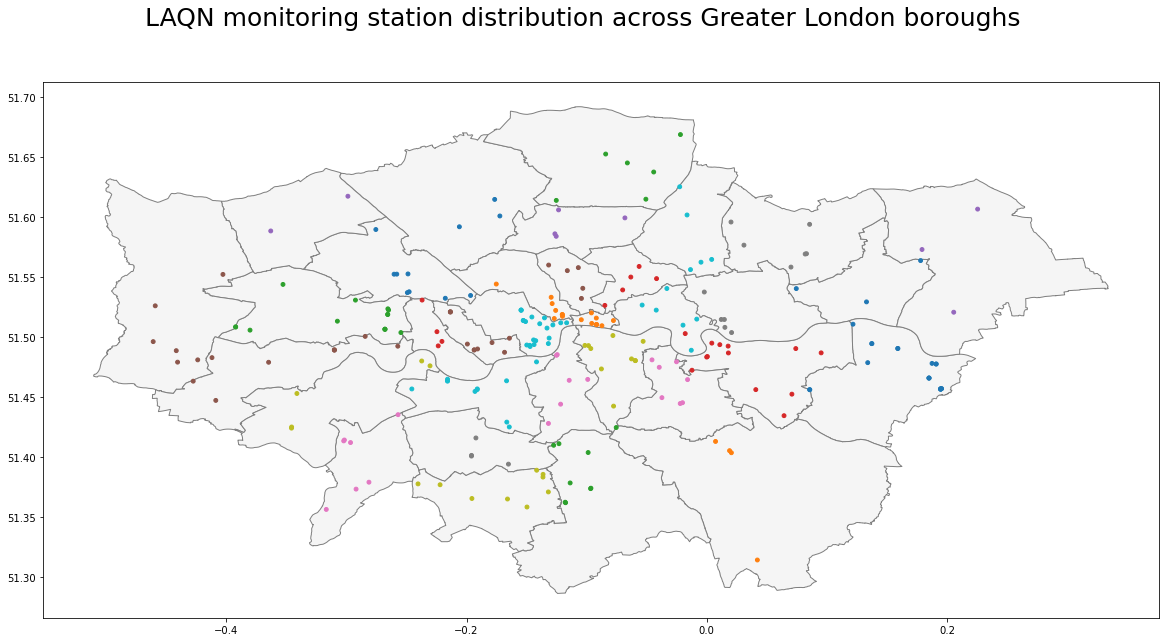

In [10]:
plot_on_map(london_sites_gdf, london_boroughs_gdf, 
            title="LAQN monitoring station distribution across Greater London boroughs", 
            data_markersize=15,  
            map_edge_color="gray", axis="on", column="@LocalAuthorityName")

In [11]:
borough_AQ_df = air_quality.local_authority_aggregation(AQ_df)

Averaging sites according to local authorities...


100%|██████████| 33/33 [05:51<00:00, 10.64s/it]


In [12]:
# borough_AQ_df = air_quality.read("laqn-local-authority")
borough_AQ_df.shape

(219169, 33)

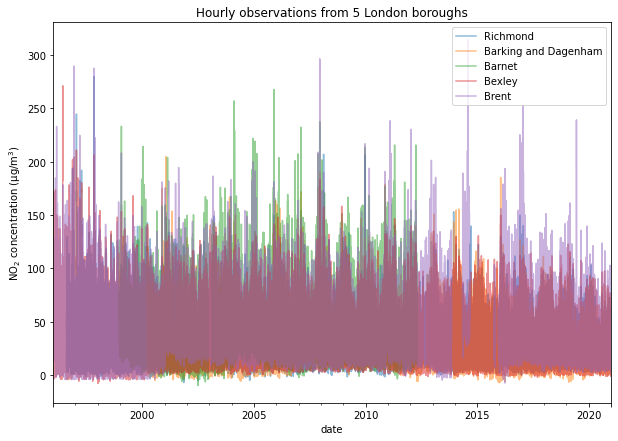

In [13]:
borough_AQ_df[borough_AQ_df.columns[0:5]].plot(alpha=0.5, figsize=(10,7))
plt.ylabel("NO$_2$ concentration (µg/m$^3$)")
plt.xlabel("date")
plt.title("Hourly observations from 5 London boroughs")
plt.show()

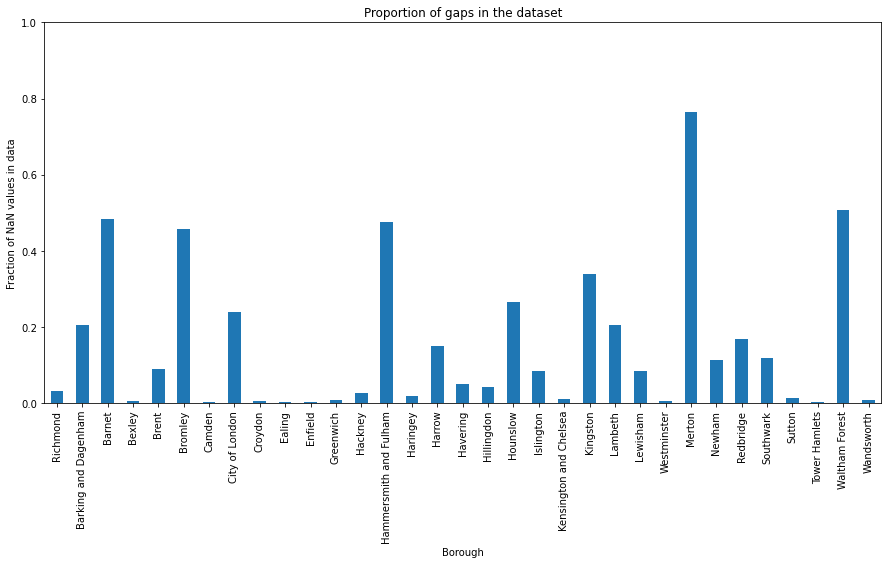

In [21]:
pd.DataFrame(borough_AQ_df.isna().sum()/len(borough_AQ_df)).plot.bar(figsize=(15,7), legend=False)
plt.ylabel("Fraction of NaN values in data")
plt.xlabel("Borough")
plt.title("Proportion of gaps in the dataset")
plt.ylim(0,1)
plt.show()